## Collateral in MIM Cauldrons

Load some useful modules and scripts

In [ ]:
from web3 import Web3
import pandas as pd
import os, sys, json
from matplotlib import pyplot as plt
import numpy as np
import re
import requests
from dotenv import load_dotenv
load_dotenv('../.env')

# Scripts
scripts_module_path = os.path.abspath(os.path.join(os.getcwd(),'..', 'scripts'))
if scripts_module_path not in sys.path:
    sys.path.append(scripts_module_path)
from acquisition import Acquisition as Akw

### Get all Markets

In [ ]:
all_markets = json.load(open('../data/abracadabra/markets.json', 'r'))   ## jsonified data from https://docs.abracadabra.money/our-ecosystem/our-contracts

In [ ]:
## Get Cauldron events from an example Cauldron
# Example: Wrapped FTM on market on Ethereum Mainnet
with open('../data/contracts/CauldronWethV2.json', 'r') as fl:
    Cauldron_specs = json.load(fl)
    Cauldron_ABI = json.dumps(Cauldron_specs["interface"])
    Cauldron_address = list(Cauldron_specs["addresses"].values())[0]
w3 = Web3(Web3.HTTPProvider(os.getenv("ALECHEMY_MAINNET_ENDPOINT")))
print("JSON RPC for Alchemy is connected: ", w3.isConnected())
weth_mim_cauldron_contract = w3.eth.contract(address=Cauldron_address, abi=Cauldron_ABI)
cauldron_event_inputs = {e["name"]:[i["name"] for i in e["inputs"]] for e in weth_mim_cauldron_contract.events._events}
print("cauldron_event_inputs: ", cauldron_event_inputs) 

In [ ]:
with open('../data/contracts/MIM_ERC20_Mainnet.json', 'r') as fl:
    ERC20_ABI = json.dumps(json.load(fl)["interface"])

In [ ]:
def get_events_dataframe(chain_name, chain_id, market, event_name, event_args, deploy_address, token_address, token_decimals, deprecated, verbose=True):
    if verbose:
        print(event_name)
    evts = getattr(cauldron_contract.events, event_name).createFilter(fromBlock='earliest', toBlock='latest').get_all_entries()
    temp_df = pd.DataFrame(data={
        arg: [e["args"][arg] for e in evts]
        for arg in event_args})
    temp_df["token"] = market["coin"]
    temp_df["event"] = event_name
    temp_df["chainName"] = chain_name
    temp_df["chainId"] = chain_id
    temp_df["cauldronAddress"] = deploy_address
    temp_df["tokenAddress"] = token_address
    temp_df["token_decimals"] = token_decimals
    temp_df["deprecatedMarket"] = deprecated
    temp_df["blockNumber"] = np.array([e["blockNumber"] for e in evts], dtype=int)
    temp_df["transactionIndex"] = np.array([e["transactionIndex"] for e in evts], dtype=int)
    return temp_df

def merge_into_df(df, right_df, deep=True):
    try:
        if deep:
            return df.merge(right_df, how="outer").copy()
        return df.merge(right_df, how="outer")
    except:
        if deep:
            return df.append(right_df, ignore_index=True).copy()
        return df.append(right_df, ignore_index=True)

In [ ]:
# initialize dataframe
df = pd.DataFrame()
collaterals = list()
# Start with Ethereum Mainnet (non-deprecated markets)
chain_name = "Ethereum Mainnet"
chain_id = 1
deprecated = False
w3 = Web3(Web3.HTTPProvider(os.getenv("ALECHEMY_MAINNET_ENDPOINT")))
print("JSON RPC for Ethereum Mainnet is connected: ", w3.isConnected())
for i, (network, markets) in enumerate(all_markets.items()):
    print('network: ', network)
    if i==1:
        deprecated = True
    if i==2:
        chain_name = "Fantom Opera"
        chain_id = 250
        deprecated = False
        w3 = Web3(Web3.WebsocketProvider('wss://wsapi.fantom.network'))
        print("Websocket for Fantom Opera is connected: ", w3.isConnected())
    if i>2:
        break

    for market in markets:
        print('The Cauldron Market is: ', market)
        deploy_address = w3.toChecksumAddress(market["address"].replace(' ',''))
        cauldron_contract = w3.eth.contract(address=deploy_address, abi=Cauldron_ABI)
        cauldron_caller = cauldron_contract.caller()
        token_address = cauldron_caller.collateral()
        token_decimals = w3.eth.contract(address=token_address, abi=ERC20_ABI).caller().decimals()
        collaterals.append({
            "token_address": token_address,
            "token_name": market,
            "chainId": chain_id
        })
        for event_name, event_args in cauldron_event_inputs.items():
            temp_df = get_events_dataframe(chain_name=chain_name,
                                           chain_id=chain_id,
                                           market=market,
                                           event_name=event_name,
                                           event_args=event_args,
                                           deploy_address=deploy_address,
                                           token_address=token_address,
                                           token_decimals=token_decimals,
                                           deprecated=deprecated)
            df = merge_into_df(df=df, right_df=temp_df, deep=True)
            del temp_df
df = df.astype({
    "amount": np.float64,
    "share": np.float64,
    "part": np.float64,
    "rate": np.float64}).copy()
        

In [122]:
df = df.sort_values(by=["blockNumber", "transactionIndex"], ignore_index=True, ascending=True).copy()

In [123]:
df.to_csv('../data/abracadabra/event_data.csv', sep=',')
# df_sorted = pd.read_csv('../data/abracadabra/event_data.csv', sep=',', index_col=0)

## Some Inspection

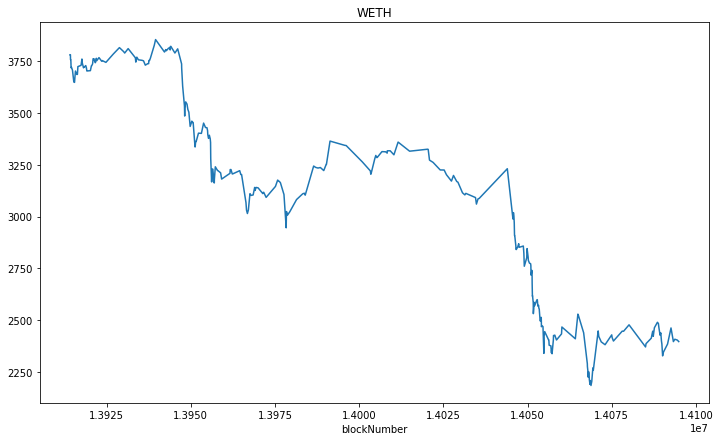

In [152]:
token = "WETH"
df_fltrd = df[(df.token==token) & (df.event=="LogExchangeRate")]
plt.plot(df_fltrd["blockNumber"].values, 1 / (df_fltrd["rate"].values / np.power(10, df_fltrd["token_decimals"].values)))
ax = plt.gca()
ax.set(title=token, xlabel='blockNumber')
fg = plt.gcf()
fg.set_figwidth(12)
fg.set_figheight(7)
plt.show()

In [208]:
token = "WETH"
chainId = 1
def add_collateral_locked(df, token, chainId):

    columns = ["blockNumber", "transactionIndex", "share", "token_decimals", "rate"]
    df_addcol = df[(df.token==token) & (df.chainId==chainId) & (df.event=="LogAddCollateral")][columns]
    df_addcol["share"] /= 10 ** df_addcol["token_decimals"]
    df_remcol = df[(df.token==token)  & (df.chainId==chainId) & (df.event=="LogRemoveCollateral")][columns]
    df_remcol["share"] /= 10 ** df_remcol["token_decimals"]
    df_coll_temp = pd.merge(df_addcol, df_remcol, on=["blockNumber", "transactionIndex"], how="outer", suffixes=("_add", "_remove"))
    df_coll_temp = df_coll_temp.fillna(value=0, inplace=False).sort_values(by=["blockNumber", "transactionIndex"], ignore_index=True, ascending=True).copy()
    df_coll_temp["locked"] = df_coll_temp.share_add.cumsum() - df_coll_temp.share_remove.cumsum()
    ## add the case exchange rate
    df_rate = df[(df.token==token) & (df.chainId==chainId) & (df.event=="LogExchangeRate")][columns]
    ## TODO!! Is the factor for the conversion into a rate 10 to the token decimals or to the MIM decimals?
    df_rate["rate_fraction"] = (df_rate["rate"].values / np.power(10, df_rate["token_decimals"].values))
    df_temp = pd.merge(df_coll_temp, df_rate, on=["blockNumber", "transactionIndex"], how="outer", suffixes=("_col", ""))
    df_temp= df_temp.sort_values(by=["blockNumber", "transactionIndex"], ignore_index=True, ascending=True).copy()
    df_temp["rate_fraction"] = df_temp.rate_fraction.fillna(method='ffill').fillna(method='bfill')
    df_temp["locked"] = df_temp["locked"].fillna(method='ffill').fillna(method='bfill')
    df_temp["locked (in USD)"] = df_temp["locked"] / df_temp["rate_fraction"]
    return df_temp
    

In [214]:
all_assets = df["token"].unique()

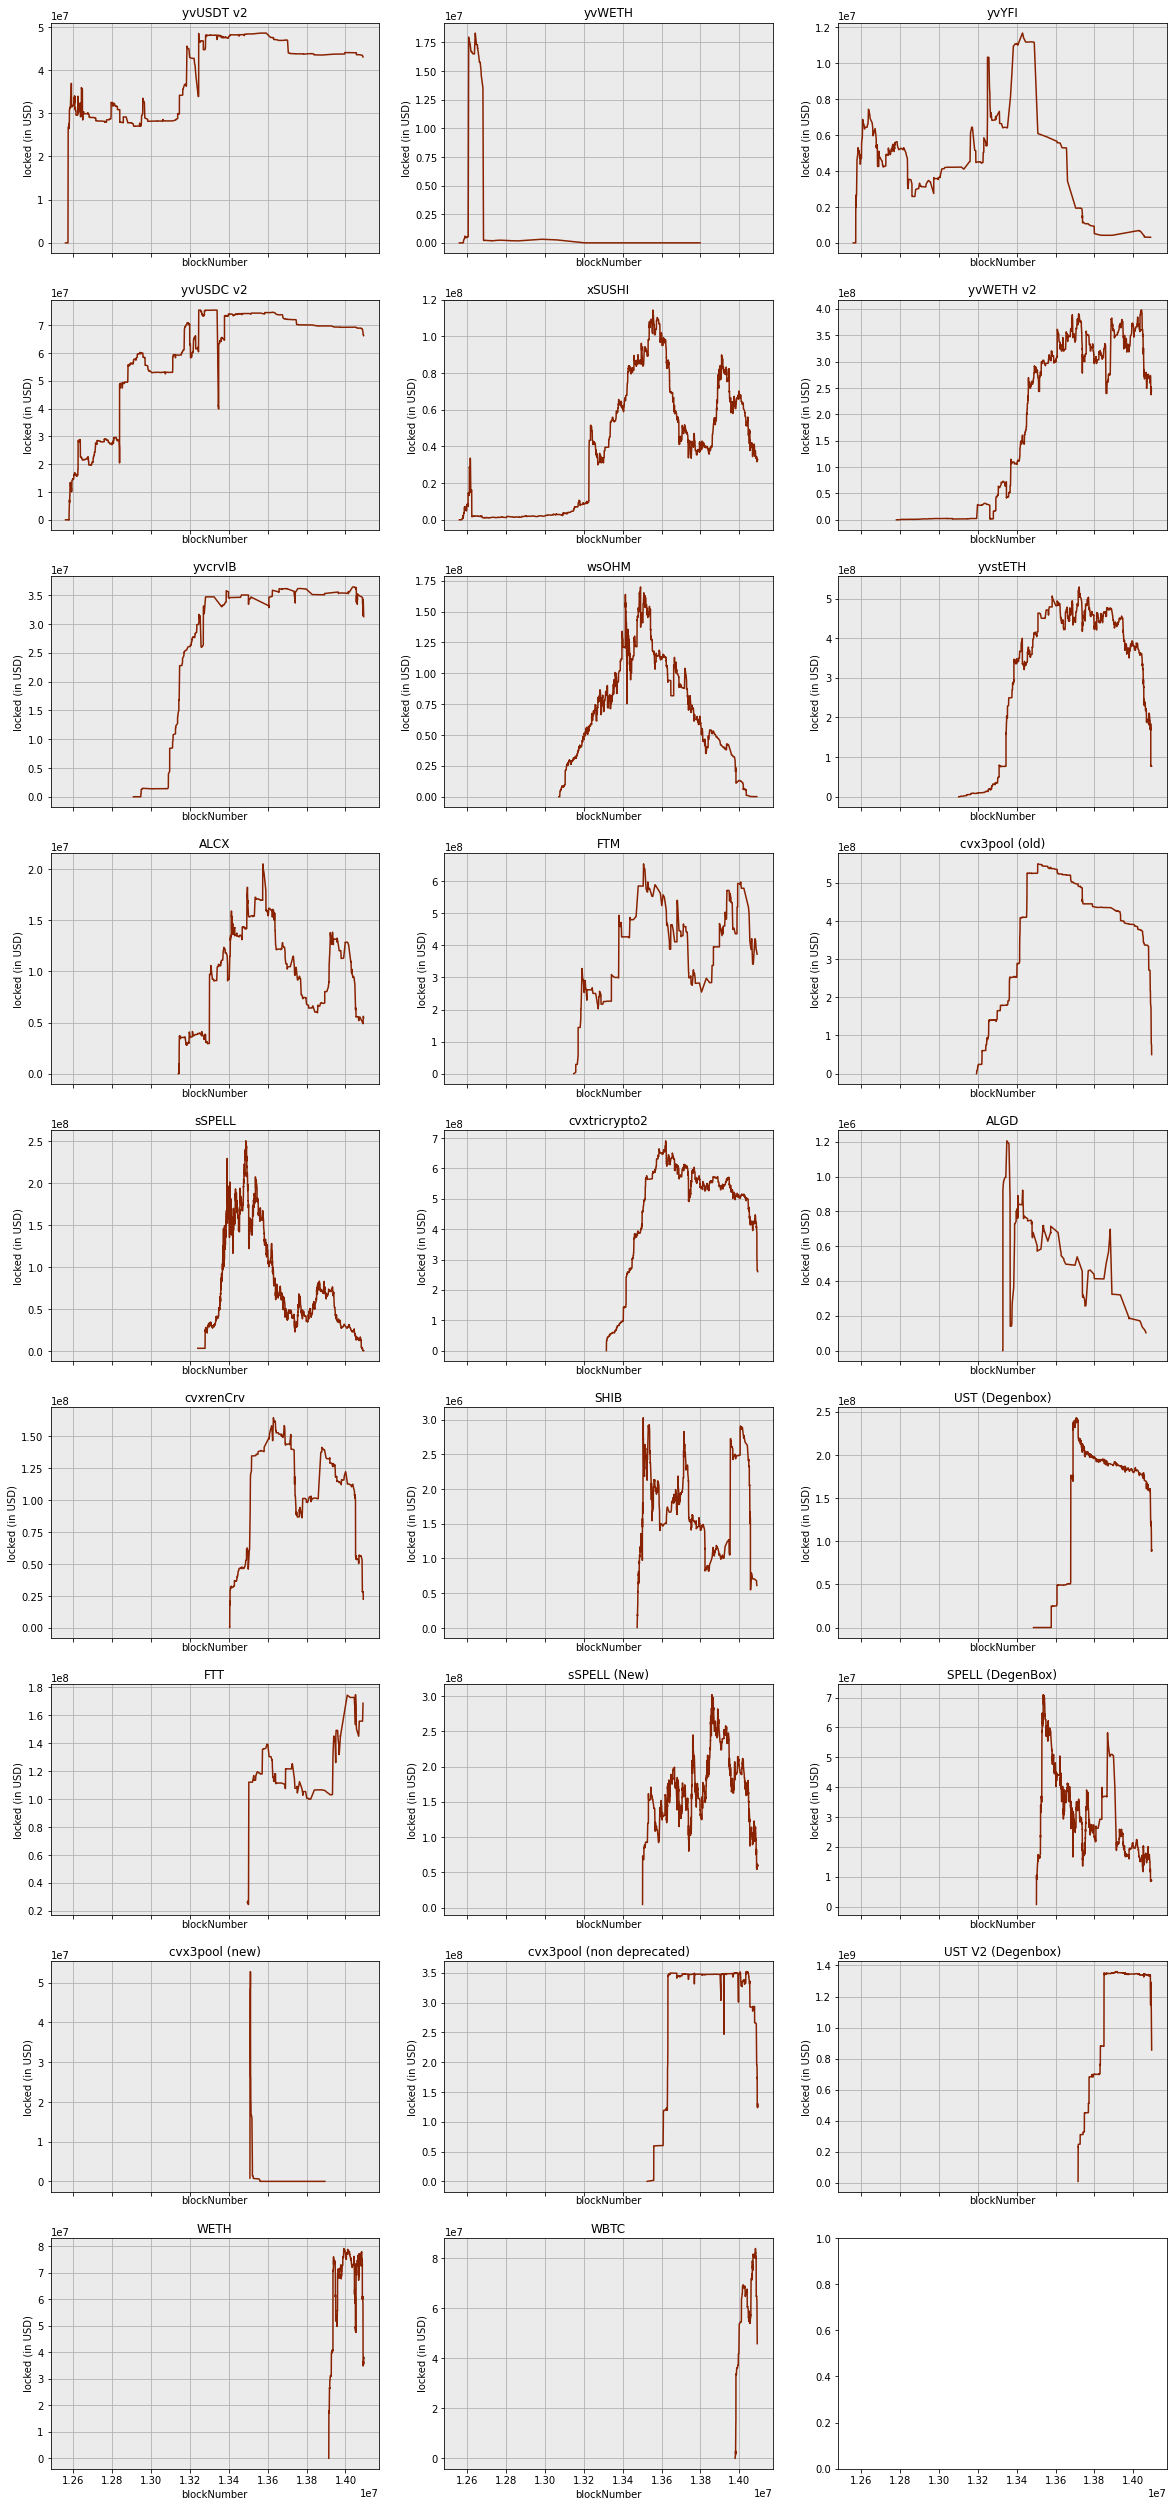

In [216]:
fig, axes = plt.subplots(nrows=int(np.ceil(len(all_assets)/3)),ncols=3,sharex=True)
fig.set_figwidth(20)
fig.set_figheight(45)
for axis, asset in zip(axes.flatten(), all_assets):
    asset_df = add_collateral_locked(df=df, token=asset, chainId=1)
    axis.plot(asset_df.blockNumber, asset_df["locked (in USD)"], color="#820")
    # axis.plot(asset_rem_col_df.blockNumber, asset_add_col_df.share, color="#280")
    axis.grid()
    axis.set_facecolor((0.92, 0.92, 0.92))
    axis.set(title=asset, xlabel="blockNumber", ylabel="locked (in USD)")
